In [1]:
import rHeston
import BlackScholes as bs
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ImpliedDrift as iD
import time
import pymc as pm
import pytensor.tensor as pt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Read the dataset

dates = np.array(["23_01_23.csv", "24_01_23.csv", "25_01_23.csv", "26_01_23.csv", "27_01_23.csv",
                  "30_01_23.csv", "06_02_23.csv", "13_02_23.csv", "21_02_23.csv"])

spot = np.array(pd.read_csv("spot.csv").Spot).flatten()
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])

index = 0
data = pd.read_csv(dates[index]); S0 = spot[index];
K = S0 * moneyness / 100

if index:
    maturities = np.array(data.Tenor).flatten()
    IV = np.array(data.drop(columns = ['Date', 'Tenor']))/100.

else:
    maturities = np.array(data['Exp Date']).flatten()
    IV = np.array(data.drop(columns = 'Exp Date'))/100.
    

maturities = maturities[maturities*365 <= 180]
    
nr = len(maturities); nc = len(K);

IV = IV[:nr]

H = np.array(pd.read_csv("rHeston_param_for_bayes.csv").H).flatten()

In [3]:
r = iD.r(maturities); q = iD.q(maturities);

true_price = np.zeros([nr, nc])
options_type = np.ones(nc)

for i in range(nr):
    true_price[i] = bs.BSCall(S0, K, maturities[i], r[i], q[i], IV[i])
            
true_price = true_price.flatten()

In [4]:
def f(theta, rho, size = None):
    
    P = np.zeros([nr, nc])
    
    for i in range(nr):
        P[i] = rHeston.analytic_rhest(S0, K, maturities[i], H, rho, theta, options_type)
    
    return P.flatten()

In [5]:
%%timeit
f(1.5, -0.8)

1.22 s ± 33.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
# Objective function 

def f(rng, theta, rho, size = None):
    
    P = np.zeros([nr, nc])
    
    for i in range(nr):
        P[i] = rHeston.analytic_rhest(S0, K, maturities[i], H, rho, theta, options_type)
    
    return P.flatten()

In [7]:
start_time = time.time()

with pm.Model() as model_lv:
    theta = pm.Uniform("theta", lower = 1e-4, upper = 3)
    rho = pm.Uniform("rho", lower = -1, upper = -1e-4)
    
    sim = pm.Simulator("sim", f, params = (theta, rho), epsilon = 20, observed = true_price)

    idata_lv = pm.sample_smc(draws = 2000, chains = 4, progressbar=False)
    
print(f'Elapsed time: {time.time()-start_time: .2f}s')

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Elapsed time:  72534.22s


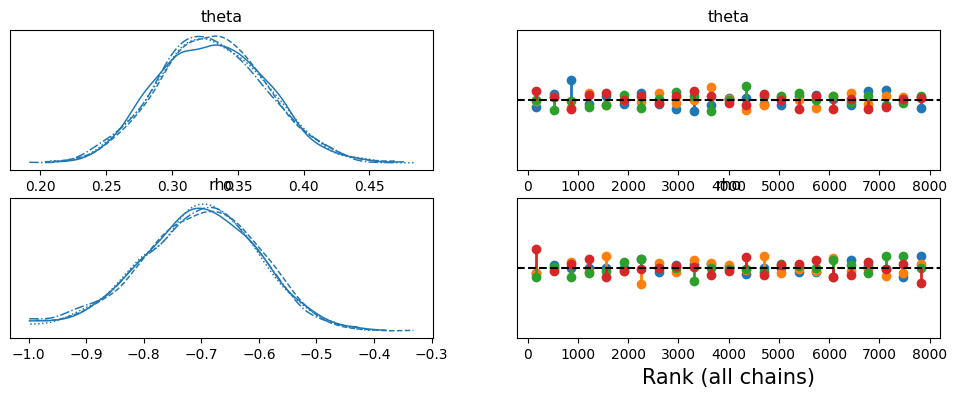

In [8]:
az.plot_trace(idata_lv, kind="rank_vlines");

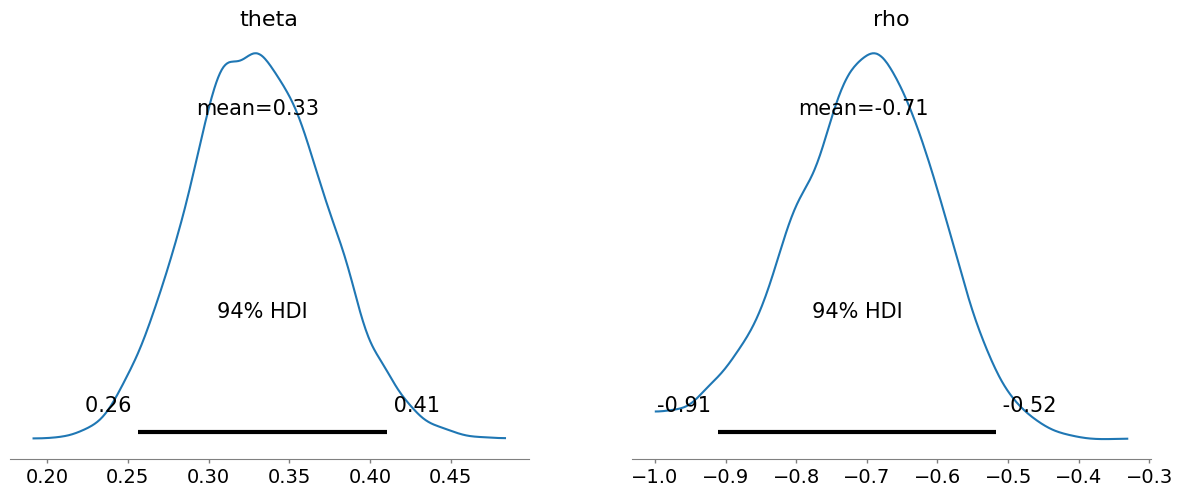

In [9]:
az.plot_posterior(idata_lv);

In [10]:
theta = np.array(pd.DataFrame(idata_lv.posterior.theta)).flatten()
rho = np.array(pd.DataFrame(idata_lv.posterior.rho)).flatten()

Theta: 0.3317015327486652


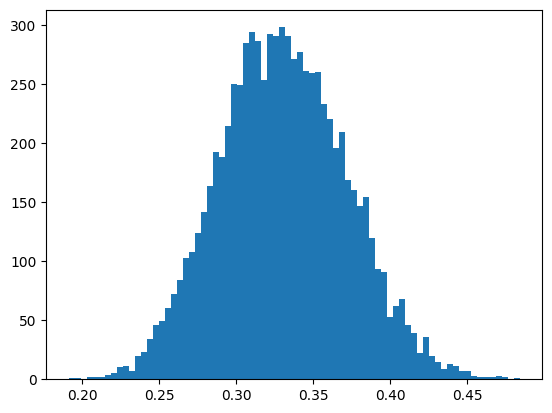

In [11]:
a = plt.hist(theta, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
x_max = (x[np.argmax(y)]+x[np.argmax(y)+1])/2
print("Theta:", x_max)

Rho: -0.6873522940850871


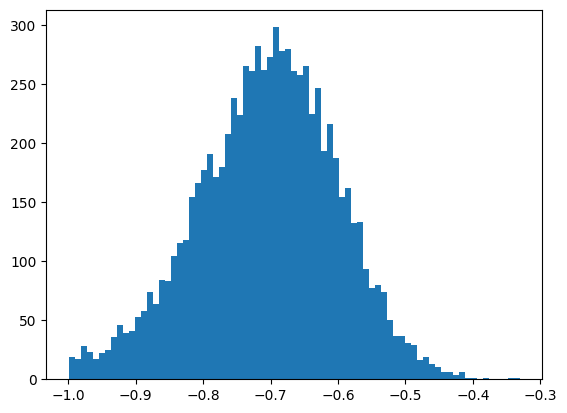

In [12]:
a = plt.hist(rho, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
x_max = (x[np.argmax(y)]+x[np.argmax(y)+1])/2
print("Rho:", x_max)

In [13]:
data = pd.concat([pd.DataFrame(rho, columns = ["rho"]), pd.DataFrame(theta, columns = ["theta"])], axis = 1)
data.to_csv("rHeston_data_no_h.csv", index = False)